In [1]:
from preprocessing.patch_generator import smash_n_reconstruct
import preprocessing.filters as f
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping
import os
from tqdm import tqdm
from PIL import Image

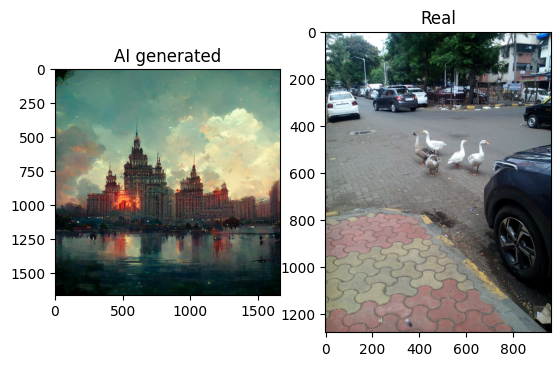

In [2]:
img1 = Image.open('./test_imgs/fake.png')
img2 = Image.open('./test_imgs/real.jpg')
plt.subplot(1,2,1)
plt.imshow(img1)
plt.title('AI generated')
plt.subplot(1,2,2)
plt.imshow(img2)
plt.title('Real')
plt.show()

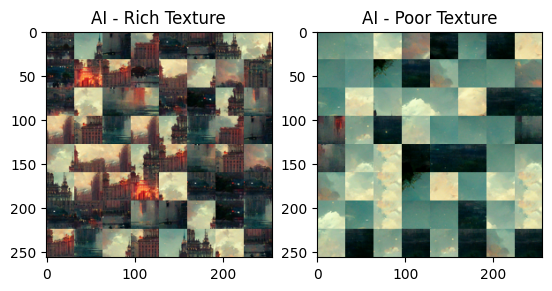

In [3]:
rt1,pt1 = smash_n_reconstruct('./test_imgs/fake.png')
plt.subplot(1,2,1)
plt.imshow(rt1,cmap='gray')
plt.title('AI - Rich Texture')
plt.subplot(1,2,2)
plt.imshow(pt1,cmap='gray')
plt.title('AI - Poor Texture')
plt.show()

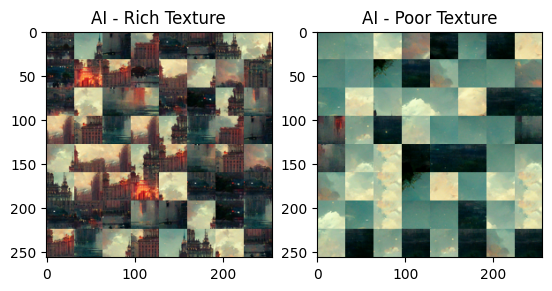

In [4]:
rt2,pt2 = smash_n_reconstruct('./test_imgs/real.jpg')
plt.subplot(1,2,1)
plt.imshow(rt1,cmap='gray')
plt.title('AI - Rich Texture')
plt.subplot(1,2,2)
plt.imshow(pt1,cmap='gray')
plt.title('AI - Poor Texture')
plt.show()

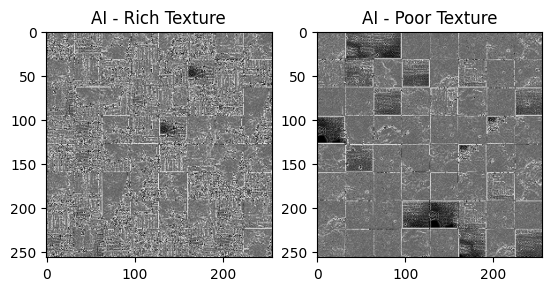

In [5]:
rt1,pt1 = smash_n_reconstruct('./test_imgs/fake.png')
plt.subplot(1,2,1)
plt.imshow(f.apply_all_filters(rt1),cmap='gray')
plt.title('AI - Rich Texture')
plt.subplot(1,2,2)
plt.title('AI - Poor Texture')
plt.imshow(f.apply_all_filters(pt1),cmap='gray')
plt.show()

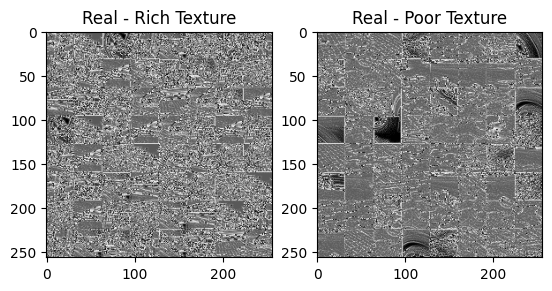

In [6]:
rt2,pt2 = smash_n_reconstruct('./test_imgs/real.jpg')
plt.subplot(1,2,1)
plt.title('Real - Rich Texture')
plt.imshow(f.apply_all_filters(rt2),cmap='gray')
plt.subplot(1,2,2)
plt.title('Real - Poor Texture')
plt.imshow(f.apply_all_filters(pt2),cmap='gray')
plt.show()

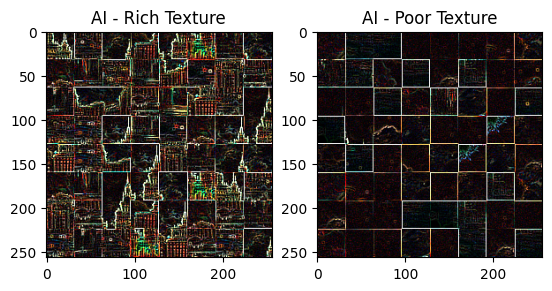

In [22]:
plt.subplot(1,2,1)
plt.imshow(f.apply_filter_a(rt1))
plt.title('AI - Rich Texture')
plt.subplot(1,2,2)
plt.imshow(f.apply_filter_a(pt1))
plt.title('AI - Poor Texture')
# plt.subplot(1,2,1)
# plt.subplots_adjust(hspace=0.3)
# plt.imshow(f.apply_filter_a(rt2))
# plt.title('Real - Rich Texture')
# plt.subplot(1,2,2)
# plt.imshow(f.apply_filter_a(pt2))
# plt.title('Real - Poor Texture')
plt.show()

In [4]:
def hard_tanh(x):
    return tf.clip_by_value(x,-1,1)

model = keras.Sequential([
        layers.Input(shape=(256,256,1)),
        layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.Lambda(hard_tanh)
    ])

model.compile(optimizer='adam',loss=keras.losses.BinaryCrossentropy,metrics=['accuracy'])
model.build()

In [6]:
import gc

In [7]:
gc.collect()

116

In [8]:
classifier = keras.Sequential([
        layers.Input(shape=(254,254,32)),
        layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu'),
        layers.BatchNormalization(),
        layers.AveragePooling2D(),
        layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu'),
        layers.BatchNormalization(),
        layers.AveragePooling2D(),
        layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu'),
        layers.BatchNormalization(),
        layers.AveragePooling2D(),
        layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Flatten(),
        layers.Dense(1,activation='sigmoid')
    ])

classifier.compile(
                    optimizer='adam',
                    loss='BinaryCrossentropy',
                    metrics='binary_accuracy'
                )

classifier.build()

In [9]:
def preprocess(path,label:int):
    rt,pt = smash_n_reconstruct(path.numpy().decode('utf-8'))
    frt = tf.constant([f.apply_all_filters(rt)])
    fpt = tf.constant([f.apply_all_filters(pt)])
    return (model.predict(frt)-model.predict(fpt))[0],label

In [10]:
def dict_map(X,y):
    return {
        'X':X,
        'y':y
    }

In [11]:
path_ai = './test_imgs/AI_SD_ukiyo-e/'
ai_imgs = [os.path.join(path_ai,img) for img in os.listdir(path_ai)]
ai_label = [1 for i in range(len(ai_imgs))]
path_real = './test_imgs/ukiyo_e/'
real_imgs = [os.path.join(path_real,img) for img in os.listdir(path_real)]
real_label = [0 for i in range(len(real_imgs))]
print(len(real_imgs),len(ai_imgs))
X_train = ai_imgs[:-20] + real_imgs[:-20]
y_train = ai_label[:-20] + real_label[:-20]
X_validate = ai_imgs[-20:] + real_imgs[-20:]
y_validate = ai_label[-20:] + real_label[-20:]
len(X_train),len(y_train)

5000 5308


(10268, 10268)

## Making data pipeline

In [12]:
batch_size = 32

In [13]:
dataset = (tf.data.Dataset.from_tensor_slices((X_train,y_train))
           .shuffle(len(X_train))
           .map(
                lambda filepath,label: 
                tf.py_function(preprocess, [filepath, label],[tf.float64, tf.int32])
            )
            .batch(batch_size)
            .prefetch(tf.data.AUTOTUNE)
        )

validation_set = (tf.data.Dataset.from_tensor_slices((X_validate,y_validate))
           .shuffle(len(X_validate))
           .map(
                lambda filepath,label: 
                tf.py_function(preprocess, [filepath, label],[tf.float64, tf.int32])
            )
            .batch(10)
            .prefetch(tf.data.AUTOTUNE)
        )

In [14]:
checkpoint_path = "./checkpoints/model_checkpoint.h5"
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, 
                                      monitor='val_loss', 
                                      save_best_only=True,
                                      save_weights_only=True,
                                      verbose=1)

# Define early stopping callback
early_stopping_callback = EarlyStopping(monitor='val_loss', 
                                        patience=3, 
                                        verbose=1, 
                                        restore_best_weights=True)


## Training the model

In [15]:
classifier.fit(dataset,epochs=5,validation_data=validation_set,callbacks=[checkpoint_callback, early_stopping_callback])

Epoch 1/5
1/1 [==============================] - 0s 358ms/step


KeyboardInterrupt: 

1/1 [==============================] - 0s 185ms/step


In [16]:
classifier.save('./classifier.h5')

c:\Users\Hriday\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 199ms/step
